# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :**

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation.

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

In [ ]:
# Imports

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Check if CUDA is available

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [ ]:
# Training
cifar10_trainset = torchvision.datasets.CIFAR10(root ="/content", train=True, download=True , transform=transforms.ToTensor())
indices_first = list(range(100))

X_train = torch.utils.data.Subset(cifar10_trainset, indices_first)
training_loader  = torch.utils.data.DataLoader(X_train)

# Test
X_test = torchvision.datasets.CIFAR10(root ="/content", train=False , download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(X_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 44093299.55it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [ ]:
# Check lengths

print("Length of full CIFAR10 train set:", len(cifar10_trainset))
print("Check length of train set with 100 samples:", len(X_train))
print("Length of full CIFAR10 test set:", len(X_test))

Length of full CIFAR10 train set: 50000
Check length of train set with 100 samples: 100
Length of full CIFAR10 test set: 10000


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project.

* The remaining samples correspond to $\mathcal{X}$.

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

<font color='blue'> All problems come from the fact that we have only selected the 100 first samples of the whole dataset.

- <font color='blue'> Problem 1: We will have limited ground truth for validation, and this can make it hard to assess how well the model generalizes to unseen data.

- <font color='blue'> Problem 2: The model might overfit to the small labeled dataset, performing well on these known samples but poorly on new, unseen data.

- <font color='blue'>Problem 3: With limited labeled data, it's challenging to measure the model's uncertainty and the variability of its predictions across the broader data distribution. This can lead to an incomplete understanding of the model's reliability.

- <font color='blue'> Problem 4: We may have an imbalance of classes. Indeed, even if it is not our case, we could have a situation where the 100 first samples of the dataset correspond to the same label. If this was the case, the model would not learn for other classes.

<font color='blue'> Several solutions can be proposed:
- <font color='blue'> Solution 1: We might create a subset of the whole training set containing 100 samples but with stratification. That is, ensuring that the samples represent well the whole training set in terms of proportion on the classes.

- <font color='blue'> Solution 2: Since the main problem is that the train set is small, we can perform data augmentation.

- <font color='blue'> Solution 3: As seen in class, this setup is ideal to use a weak supervision technique (self-supervised or semi-supervised).

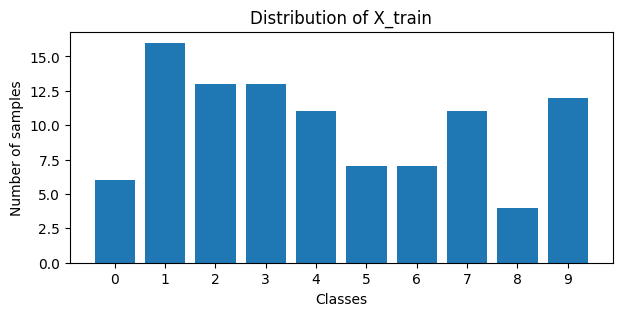

In [ ]:
# This cell is intended to explore Problem 4, by the visualization of the distribution of X_train (first 100 samples)

labels=[]
for sample,label in training_loader:
  labels.append(label.item())
nbr = np.unique(np.array(labels),return_counts=True)

# Plot
plt.figure(figsize=(7,3))
plt.bar(nbr[0],nbr[1])
plt.xticks(nbr[0])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Distribution of X_train')
plt.show()

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf.

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
'''ResNet in PyTorch. This code is taken from  https://github.com/kuangliu/pytorch-cifar

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
def train(model, total_epochs, opt, lr_scheduler, loss_func, data_loader, log_verbose=True, device='cuda', initial_epoch=0):

    model.to(device)
    accuracy_history, loss_history = [], []

    # Training loop
    for epoch in range(initial_epoch, total_epochs + initial_epoch):
        model.train()  # We set the model to training mode

        total_loss, correct_predictions, total_samples = 0, 0, 0

        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()
            predictions = model(inputs)
            loss = loss_func(predictions, labels)
            loss.backward()
            opt.step()

            # We accumulate metrics
            total_loss += loss.item()
            total_samples += labels.size(0)
            correct_predictions += (predictions.argmax(1) == labels).sum().item()

        # We can now calculate epoch metrics and update histories
        epoch_accuracy = 100 * correct_predictions / total_samples
        average_loss = total_loss / len(data_loader)

        accuracy_history.append(epoch_accuracy)
        loss_history.append(average_loss)

        # Optionally print
        if log_verbose and (epoch % 5 == 0 or epoch == total_epochs + initial_epoch - 1):
            print(f'Epoch: {epoch} | Train Loss: {average_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%')

    return accuracy_history, loss_history

In [ ]:
def test(model, loss_function, device, data_loader, display_output=True):

    # We set the model to evaluation mode
    model.eval()

    # Initialize metrics
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)

            # We calculate and accumulate the loss
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # ... and the accuracy
            preds = outputs.argmax(dim=1)
            total_correct += (preds == targets).sum().item()
            total_samples += targets.size(0)

    # We can now calculate final metrics
    average_loss = total_loss / len(data_loader)
    accuracy = 100 * (total_correct / total_samples)

    # Optionally print results
    if display_output:
        print(f'Test Loss: {average_loss:.4f} | Test Accuracy: {accuracy:.2f}%')

    return accuracy

In [ ]:
# We create a function to plot the training accuracy and loss history over epochs.

def plot_training_metrics(training_accuracy, loss_history):

    epochs = range(1, len(training_accuracy) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(epochs, training_accuracy, 'b-', label='Accuracy')
    axes[0].set_title('Training Accuracy Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs, loss_history, 'r-', label='Loss')
    axes[1].set_title('Training Loss Over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Training:
Epoch: 0 | Train Loss: 3.2316 | Train Accuracy: 8.00%
Epoch: 5 | Train Loss: 1.2604 | Train Accuracy: 57.00%
Epoch: 10 | Train Loss: 0.5535 | Train Accuracy: 84.00%
Epoch: 15 | Train Loss: 0.2554 | Train Accuracy: 91.00%
Epoch: 20 | Train Loss: 0.2059 | Train Accuracy: 96.00%
Epoch: 25 | Train Loss: 0.1943 | Train Accuracy: 95.00%
Epoch: 30 | Train Loss: 0.0466 | Train Accuracy: 98.00%
Epoch: 35 | Train Loss: 0.0142 | Train Accuracy: 100.00%
Epoch: 39 | Train Loss: 0.0038 | Train Accuracy: 100.00%

Testing:
Test Loss: 4.4549 | Test Accuracy: 24.16%


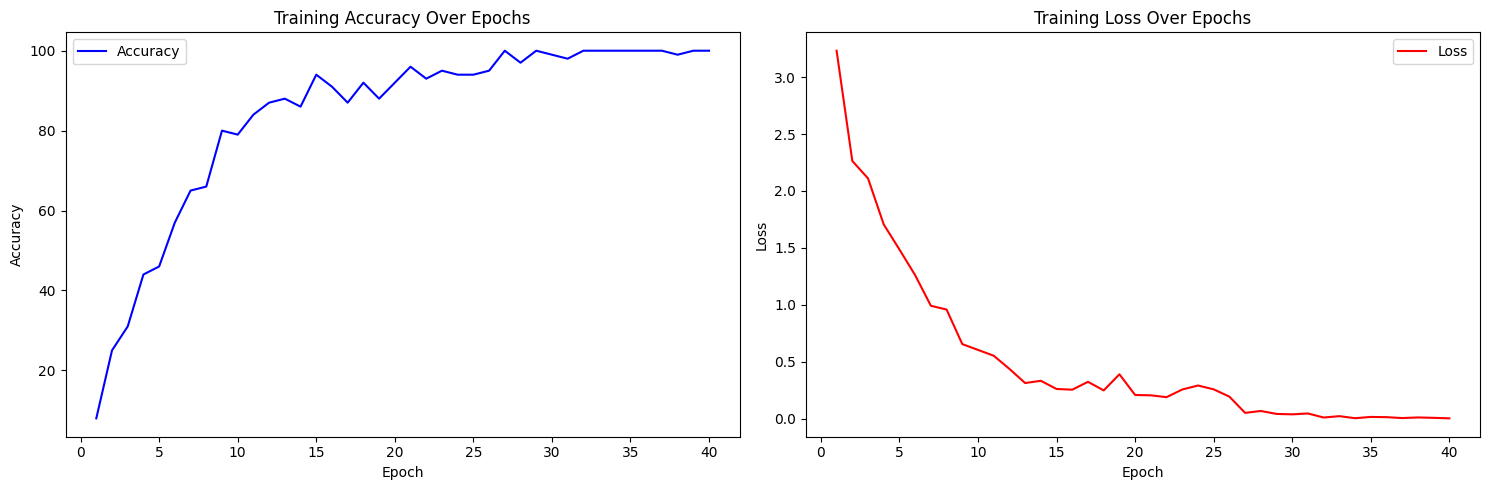

In [ ]:
# Epochs and batch size
num_epochs = 40
batch_size = 20

# We must create again the dataloaders to take into account the batch size
training_loader  = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False)

# Define model
neural_net = ResNet18()
loss_function = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(neural_net.parameters(), lr=1e-3)
lr_sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.1)


print("Training:")
train_accuracy, training_loss = train(neural_net, num_epochs, optim, lr_sched, loss_function, training_loader, log_verbose=True, device='cuda')

print("\nTesting:")
test_accuracy = test(neural_net, loss_function, 'cuda', test_loader, display_output=True)

# Plot training metrics
plot_training_metrics(train_accuracy, training_loss)

<font color='blue'>
The following table presents the results obtained training a ResNet-18 on X_train (only 100 samples). It also presents the accuracy obtained by https://github.com/kuangliu/pytorch-cifar also using a ResNet-18 architecture.

| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on full data
|------|------|------|------|------|
|   ResNet-18  | 30 | 100% | 24.16% | 93.02%




# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
# We decide to take the ResNet18 model, in order to have te same architecture than for the Baseline

class Modified_Net(nn.Module):

    def __init__(self):
        super().__init__()

        # Backbone model
        self.model = models.resnet18(pretrained=True)
        self.n_features = self.model.fc.in_features # self.model.fc.in_features retrieves the number of input features to the final fully connected layer of ResNet18
        self.layers = list(self.model.children())[:-1] # This line selects all layers of the ResNet18 model except for its final classification layer, which we remove
        self.backbone = nn.Sequential(*self.layers)

        # We add 3 final FC layer
        self.fc1 = nn.Linear(self.n_features, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

      x = self.backbone(x)
      x = x.squeeze(3).squeeze(2) # we need to remove singleton dimensions
      x = self.fc1(x)
      x = self.fc2(x)

      return self.fc3(x)

In [ ]:
def retrain_test_second_half(epochs, train_loader, lr) :

  model = Modified_Net()
  criterion = torch.nn.CrossEntropyLoss()
  optim = torch.optim.Adam(neural_net.parameters(), lr=1e-3)
  lr_sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.1)

   # We choose to retrain the second half of the architecture

  for param in model.parameters():
    param.requires_grad = True

  child_nbrs = 0
  for child in model.children():
    child_nbrs += 1

  child_counter = 0
  for child in model.children():
    if child_counter < child_nbrs//2 :
        child_counter += 1
        for param in child.parameters():
            param.requires_grad = False

  for param in model.fc1.parameters():
    param.requires_grad = True

  for param in model.fc2.parameters():
    param.requires_grad = True

  for param in model.fc3.parameters():
    param.requires_grad = True

  train_accuracy , training_loss = train(model,epochs,optim, lr_sched, criterion,train_loader,device="cuda")

  print("\nTesting")
  test_accuracy = test(model, criterion, device, test_loader)

In [ ]:
# Epochs and batch size
num_epochs = 60
batch_size = 20

# We must create again the dataloaders to take into account the batch size
training_loader  = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False)

# Rerain the second half of the architecture
retrain_test_second_half(epochs = num_epochs, train_loader=training_loader, lr = 1e-2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Epoch: 0 | Train Loss: 2.3279 | Train Accuracy: 14.00%
Epoch: 5 | Train Loss: 1.8925 | Train Accuracy: 39.00%
Epoch: 10 | Train Loss: 1.4380 | Train Accuracy: 59.00%
Epoch: 15 | Train Loss: 1.0934 | Train Accuracy: 70.00%
Epoch: 20 | Train Loss: 0.7513 | Train Accuracy: 82.00%
Epoch: 25 | Train Loss: 0.6156 | Train Accuracy: 85.00%
Epoch: 30 | Train Loss: 0.4431 | Train Accuracy: 87.00%
Epoch: 35 | Train Loss: 0.3267 | Train Accuracy: 93.00%
Epoch: 40 | Train Loss: 0.2625 | Train Accuracy: 98.00%
Epoch: 45 | Train Loss: 0.3045 | Train Accuracy: 93.00%
Epoch: 50 | Train Loss: 0.2426 | Train Accuracy: 94.00%
Epoch: 55 | Train Loss: 0.3012 | Train Accuracy: 91.00%
Epoch: 59 | Train Loss: 0.3234 | Train Accuracy: 90.00%

Testing
Test Loss: 3.8804 | Test Accuracy: 22.68%


 <font color='blue'> Results obtained:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet-18  | 60 | 90% | 22.68% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

<font color='blue'> **Problems:**

- <font color='blue'> Translations: Minor positional adjustments can lead to considerable alterations in the pixel configuration of low-resolution images, such as 32x32 pixels. These adjustements can cause important details to be lost or create vague and misleading features in the image as a result of the presence of the boundary (lost of a part of the image).

- <font color='blue'>  Rotations: When an image is rotated (by a non-multiple of $\pi$), the misalignment with the pixel grid can result in aliasing and the appearance of jagged edges. This also lead to a loss of information, and it is even more accentuated for images with low resolution (like here, 32x32).

- <font color='blue'> Scaling Effects: Scaling down from a 32×32 resolution can cause a loss of detail, making it difficult to recognize objects or features. Scaling up from such a low resolution introduces pixelation and blur.

- <font color='blue'> Color Changes: Applying color modifications to an RGB image impacts not only the color aspects but also the intensity levels, leading to images with unusual colorations. This effect arises because the RGB channels are highly correlated, affecting both color and intensity when we alter them.

<font color='blue'> **Solutions**

- <font color='blue'> Anti-aliasing Techniques: We can use anti-aliasing when rotating or scaling to reduce the jagged edges effect. Anti-aliasing makes the image smoother by adding intermediate colors at the edges, which can help to retain the perceived shapes despite the low resolution.

- <font color='blue'> Super-resolution Techniques: We can also implement super-resolution algorithms to recover the details on scaled-up images.

- <font color='blue'> Adaptive Scaling [1]: Rather than using a fixed scale factor, adaptive scaling can adjust based on the content of the image, and this can help preserve important details by scaling less aggressively in areas with much more details.

- <font color='blue'> HSV Color Space Transformation: Transforming the image into a HSV color space before applying color changes can help retain more intensity information about the original image.


<font color='blue'> [1] T. Li, B. Jing, N. Ying, and X. Yu, “Adaptive scaling,” arXiv:1709.00566, 2017.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

 <font color='blue'> For this part, notice that the order in which we apply transformations is important. Indeed, structural modifications (flips, crop) are applied first, followed by appearance modifications (blur, color jitter), and finally, the image is converted to the appropriate format (tensor) and normalized for model training.

In [ ]:
batch_size = 20

# We first define the transformations to apply. We have tested several transformations,
# but we estimated that the following were the ones which enhanced the most our model

train_transformations = transforms.Compose([
                 transforms.RandomHorizontalFlip(),
                # transforms.RandomVerticalFlip(),
                 transforms.RandomCrop(size=[32,32], padding=3),
                 transforms.GaussianBlur(kernel_size=(3,3)),
                 transforms.ColorJitter(hue=.1),
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

test_transformations = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

# We import the data one more time to ensure that the above transformations are applied:
# Training
cifar10_trainset = torchvision.datasets.CIFAR10(root ="/content", train=True, download=True , transform=train_transformations)
indices_first = list(range(100))

X_train = torch.utils.data.Subset(cifar10_trainset, indices_first)
training_loader  = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

# Test
X_test = torchvision.datasets.CIFAR10(root ="/content", train=False , download=True, transform=test_transformations)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Training:
Epoch: 0 | Train Loss: 2.4472 | Train Accuracy: 7.00%
Epoch: 5 | Train Loss: 1.9329 | Train Accuracy: 34.00%
Epoch: 10 | Train Loss: 1.7187 | Train Accuracy: 41.00%
Epoch: 15 | Train Loss: 1.4404 | Train Accuracy: 48.00%
Epoch: 20 | Train Loss: 1.2865 | Train Accuracy: 57.00%
Epoch: 25 | Train Loss: 1.0775 | Train Accuracy: 64.00%
Epoch: 30 | Train Loss: 0.9011 | Train Accuracy: 70.00%
Epoch: 35 | Train Loss: 0.7015 | Train Accuracy: 84.00%
Epoch: 40 | Train Loss: 0.5625 | Train Accuracy: 91.00%
Epoch: 45 | Train Loss: 0.4193 | Train Accuracy: 91.00%
Epoch: 50 | Train Loss: 0.3511 | Train Accuracy: 91.00%
Epoch: 55 | Train Loss: 0.2834 | Train Accuracy: 94.00%
Epoch: 60 | Train Loss: 0.2817 | Train Accuracy: 95.00%
Epoch: 64 | Train Loss: 0.1798 | Train Accuracy: 95.00%

Testing:
Test Loss: 3.2406 | Test Accuracy: 26.59%


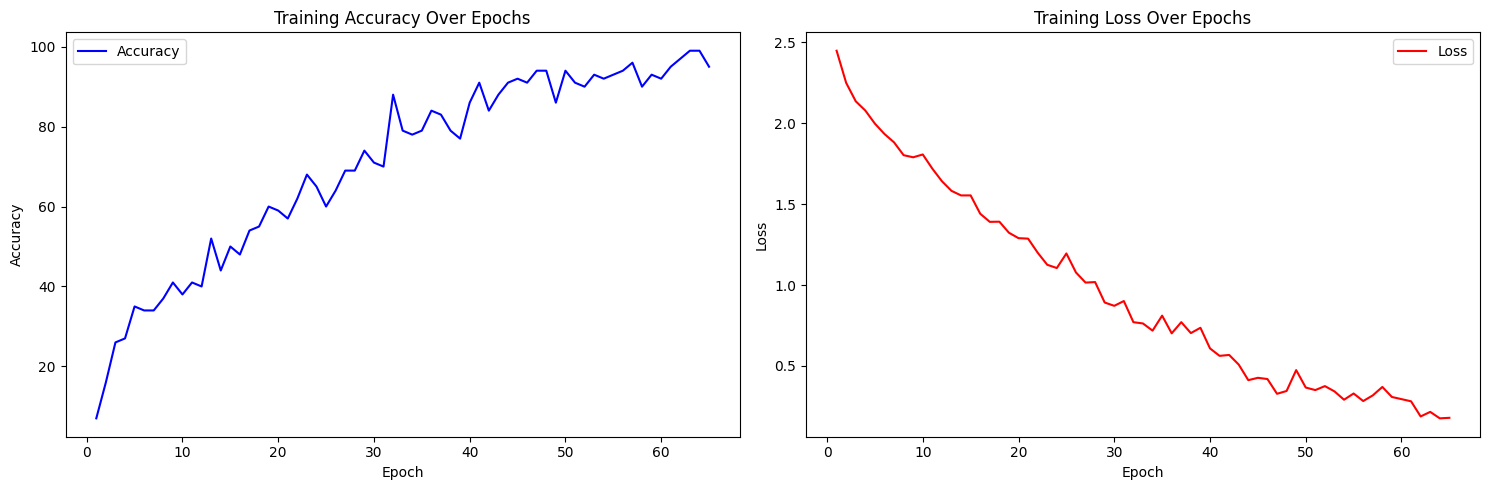

In [ ]:
# Retrain with data augmentation

# Epochs
num_epochs = 65

# Define model
neural_net = ResNet18()
loss_function = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(neural_net.parameters(), lr=1e-3, momentum=0.8)
lr_sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.1)

print("Training:")
train_accuracy, training_loss = train(neural_net, num_epochs, optim, lr_sched, loss_function, training_loader, log_verbose=True, device='cuda')

print("\nTesting:")
test_accuracy = test(neural_net, loss_function, 'cuda', test_loader, display_output=True)

# Plot training metrics
plot_training_metrics(train_accuracy, training_loss)

<font color='blue'>
The following table presents the results obtained training a ResNet-18 on X_train (only 100 samples) but with data augmentation (remember that we obtained an accuracy of 24.16% without it).

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet-18  | 65 | 95% | 26.59% |

<font color='blue'>  We observe that we obtain an accuracy more than 2% higher on the test set, which is what we expected, since data augmentation enhances model robustness and generalization by introducing varied and realistic modifications to training data.

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

<font color='blue'> In this project, we have implemented 3 methods:
1. <font color='blue'> Training a ResNet-18 from scratch on X_train without data augmentation.
2. <font color='blue'> Re-train the second half of a ResNet-18 trained on ImageNet and adapt it to CIFAR-10.
3.  <font color='blue'> Training a ResNet-18 from scratch on X_train with data augmentation.

<font color='blue'> **Method 1**

<font color='blue'> Pros: The model learns purely from the original dataset, capturing the specific characteristics and nuances without any artificially introduced variability. It is also simpler to implement than a strategy with data augmentation.

<font color='blue'>Cons: Since X_tran only have 100 samples, the model quickly overfits to the training data, learning noise and specific details that do not generalize well to unseen data.

<font color='blue'> **Method 2**

<font color='blue'> Pros: Leveraging pretrained weights enables us to retrain only a small part of the architecture (here, only the second half), which implies more efficiency. Moreover, pretraining on ImageNet, which contains a wide variety of images, helps the generalize better to CIFAR-10, with fewer data points.

<font color='blue'> Cons: There can be a mismatch in feature distribution between ImageNet and CIFAR-10, which might affect the effectiveness of the transferred features. Moreover, fine-tuning should be done carefully and a pre-trained mdoel is required.


<font color='blue'> **Method 3**

<font color='blue'> Pros: Data augmentation introduces variability that helps the model generalize better to unseen data by simulating different viewing conditions. It also effectively increases the size of the training dataset, and hence the model takes more time to overfit to the training data.

<font color='blue'> Cons: Training on augmented data significantly increase the computational cost and time required for training, as it increases the size of the dataset. Moreover, as we have confirmed with our tests, choosing inappropriate data augmentation techniques can introduce misleading information or noise, potentially harming the model's performance.

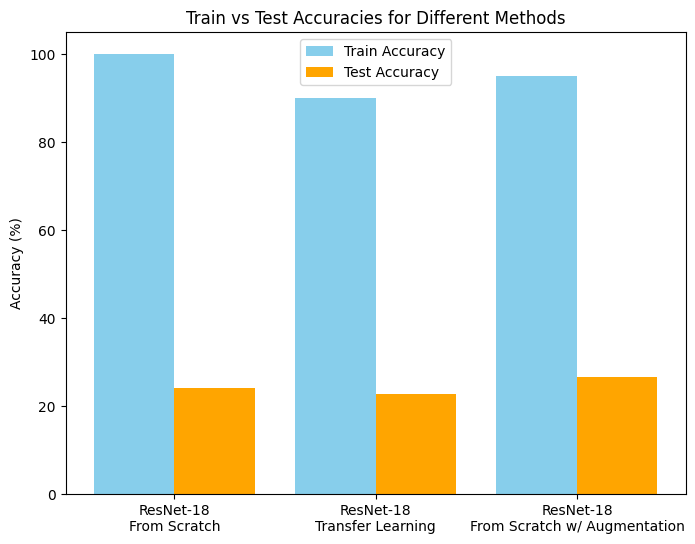

In [ ]:
# Plot summarizing train and test accuracies obtained

methods = ['ResNet-18\nFrom Scratch', 'ResNet-18\nTransfer Learning', 'ResNet-18\nFrom Scratch w/ Augmentation']
train_accuracies = [100, 90, 95]
test_accuracies = [24.16, 22.68, 26.59]


fig, ax = plt.subplots(figsize=(8, 6))
positions = list(range(len(methods)))
width = 0.4

plt.bar([p - width/2 for p in positions], train_accuracies, width, label='Train Accuracy', color='skyblue')
plt.bar([p + width/2 for p in positions], test_accuracies, width, label='Test Accuracy', color='orange')

ax.set_xticks(positions)
ax.set_xticklabels(methods)
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracies for Different Methods')
plt.legend()
plt.show()


# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.